In [1]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [2]:
def load_classifier_prediction(classifier: str, path: str, rep: int):
    return pd.read_csv(
        f"../../results/ml-eval-conn/{path}/predict/{classifier}-{rep}.csv",
        header=0
    )

def load_results():
    combinations = [
        (classifier, factor, rep) for classifier in ["kfp", "dfnet"]
        for factor in [
            "front", "tamaraw", "front/filtered", "tamaraw/filtered",
            "simulated-front", "simulated-tamaraw", "simulated-front/filtered", "simulated-tamaraw/filtered",
            "undefended", "undefended/filtered",
        ]
        for rep in range(1)
    ]
        
    return (pd.concat([
        load_classifier_prediction(classifier, factor, rep)
        for (classifier, factor, rep) in combinations
    ], keys=combinations, names=["classifier", "factor", "run", "sample"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .drop(columns=[-1]))


data = load_results()
data

y_true             0             1  \
classifier factor              run sample                                       
kfp        front               0   0         -1.0  0.000000e+00  0.000000e+00   
                                   1         -1.0  0.000000e+00  0.000000e+00   
                                   2         -1.0  0.000000e+00  0.000000e+00   
                                   3         -1.0  0.000000e+00  0.000000e+00   
                                   4         -1.0  0.000000e+00  0.000000e+00   
...                                           ...           ...           ...   
dfnet      undefended/filtered 0   3995      99.0  6.214131e-15  2.064876e-12   
                                   3996      99.0  6.808307e-16  4.350240e-13   
                                   3997      99.0  3.256111e-16  2.956889e-13   
                                   3998      99.0  6.324308e-15  5.488326e-12   
                                   3999      99.0  8.288326e-15  5.113519e-12   

                                                      2             3  \
classifier factor              run sample                               
kfp        front               0   0       0.000000e+00  0.000000e+00   
                                   1       0.000000e+00  0.000000e+00   
                                   2       0.000000e+00  0.000000e+00   
                                   3       0.000000e+00  0.000000e+00   
                                   4       0.000000e+00  0.000000e+00   
...                                                 ...           ...   
dfnet      undefended/filtered 0   3995    5.016164e-14  4.526008e-14   
                                   3996    1.151819e-14  4.531628e-15   
                                   3997    5.415627e-15  2.180579e-15   
                                   3998    6.361209e-14  5.832922e-14   
                                   3999    1.222189e-13  6.544140e-14   

                                                      4             5  \
classifier factor              run sample                               
kfp        front               0   0       0.000000e+00  0.000000e+00   
                                   1       0.000000e+00  0.000000e+00   
                                   2       0.000000e+00  0.000000e+00   
                                   3       0.000000e+00  0.000000e+00   
                                   4       0.000000e+00  0.000000e+00   
...                                                 ...           ...   
dfnet      undefended/filtered 0   3995    5.781703e-14  1.261087e-14   
                                   3996    3.668257e-15  1.252048e-15   
                                   3997    1.951767e-15  7.592839e-16   
                                   3998    1.331695e-13  1.750195e-14   
                                   3999    8.559637e-14  3.100953e-14   

                                                      6             7  \
classifier factor              run sample                               
kfp        front               0   0       0.000000e+00  0.000000e+00   
                                   1       0.000000e+00  0.000000e+00   
                                   2       0.000000e+00  0.000000e+00   
                                   3       0.000000e+00  0.000000e+00   
                                   4       0.000000e+00  0.000000e+00   
...                                                 ...           ...   
dfnet      undefended/filtered 0   3995    1.569747e-14  1.285695e-13   
                                   3996    1.889021e-15  2.226295e-14   
                                   3997    5.139767e-16  1.007459e-14   
                                   3998    1.966012e-14  1.559730e-13   
                                   3999    1.512544e-14  1.688599e-13   

                                                      8  ...            90  \
classifier factor              run sample                ... 

In [3]:
def precision_recall_curve(df):
    return pd.DataFrame(lab.analytics.rprecision_recall_curve(
        df["y_true"], df.drop("y_true", axis=1), ratio=20
    )._asdict())

In [4]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
            .reset_index())
    display(data)

    with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        grid = sns.relplot(
            data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
            style="factor", col="classifier", kind="line", 
            facet_kws=dict(legend_out=True, despine=False,
                           gridspec_kws=dict(wspace=.1)),
            palette="binary", legend=True
        )
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            # if i == 0:
            #     ax.legend(labels=["Unmon.", "Control", "Both"])
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
        
    return grid

In [5]:
data2 = (data.groupby(["classifier", "factor"])
             .apply(precision_recall_curve)
             .set_index("thresholds", append=True))
data2
            

precision  recall
classifier factor                thresholds                   
dfnet      front               0 0.000        0.039000  0.8190
                               1 0.001        0.040346  0.8190
                               2 0.002        0.040951  0.8190
                               3 0.003        0.041575  0.8190
                               4 0.004        0.041869  0.8185
...                                                ...     ...
kfp        undefended/filtered 2 0.333        0.556185  0.9825
                               3 0.500        0.614878  0.9795
                               4 0.667        0.696774  0.9720
                               5 0.833        0.696774  0.9720
                               6 1.000        0.785802  0.9630

[6497 rows x 2 columns]

In [8]:
plot_data = data2.copy()
factors = plot_data.index.get_level_values("factor")
plot_data["is_filtered"] = factors.str.contains("filtered")
plot_data["is_simulated"] = factors.str.contains("simulated")
plot_data["defence"] = ""
plot_data.loc[factors.str.contains("tamaraw"), "defence"] = "tamaraw"
plot_data.loc[factors.str.contains("front"), "defence"] = "front"
plot_data.loc[factors.str.contains("undefended"), "defence"] = "undefended"
plot_data = plot_data.reset_index()
# plot_data["factor"] = plot_data["factor"].replace({
#     "control-dataset": "control",
#     "control-dataset-filtered": "control",
#     "front-dataset": "front",
#     "front-dataset-filtered": "front",
#     "sim-front-dataset": "sim-front",
#     "sim-front-dataset-filtered": "sim-front",
#     "tamaraw-dataset": "tamaraw",
#     "tamaraw-dataset-filtered": "tamaraw",
#     "sim-tamaraw-dataset": "sim-tamaraw",
#     "sim-tamaraw-dataset-filtered": "sim-tamaraw",
# })
plot_data



,classifier,factor,level_2,thresholds,precision,recall,is_filtered,is_simulated,defence
0,dfnet,front,0,0.000,0.039000,0.8190,False,False,front
1,dfnet,front,1,0.001,0.040346,0.8190,False,False,front
2,dfnet,front,2,0.002,0.040951,0.8190,False,False,front
3,dfnet,front,3,0.003,0.041575,0.8190,False,False,front
4,dfnet,front,4,0.004,0.041869,0.8185,False,False,front
...,...,...,...,...,...,...,...,...,...
6492,kfp,undefended/filtered,2,0.333,0.556185,0.9825,True,False,undefended
6493,kfp,undefended/filtered,3,0.500,0.614878,0.9795,True,False,undefended
6494,kfp,undefended/filtered,4,0.667,0.696774,0.9720,True,False,undefended
6495,kfp,undefended/filtered,5,0.833,0.696774,0.9720,True,False,undefended


,classifier,factor,level_2,thresholds,precision,recall,is_filtered,is_simulated,defence
0,dfnet,front,0,0.000,0.039000,0.8190,False,False,front
1,dfnet,front,1,0.001,0.040346,0.8190,False,False,front
2,dfnet,front,2,0.002,0.040951,0.8190,False,False,front
3,dfnet,front,3,0.003,0.041575,0.8190,False,False,front
4,dfnet,front,4,0.004,0.041869,0.8185,False,False,front
...,...,...,...,...,...,...,...,...,...
6492,kfp,undefended/filtered,2,0.333,0.556185,0.9825,True,False,undefended
6493,kfp,undefended/filtered,3,0.500,0.614878,0.9795,True,False,undefended
6494,kfp,undefended/filtered,4,0.667,0.696774,0.9720,True,False,undefended
6495,kfp,undefended/filtered,5,0.833,0.696774,0.9720,True,False,undefended


/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible

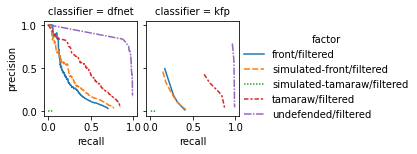

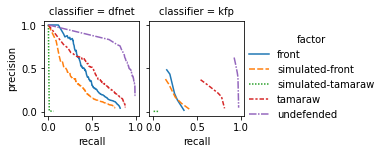

In [9]:
display(plot_data)

sns.relplot(
    data=plot_data[plot_data["is_filtered"] == True], x="recall", y="precision", col="classifier", hue="factor", style="factor",
    facet_kws=dict(legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)),
    legend=True, kind="line", height=1.75, aspect=1
).savefig("../../results/plots/ml-eval-prcurve-filtered.png", bbox_inches="tight", dpi=150)

sns.relplot(
    data=plot_data[plot_data["is_filtered"] == False], x="recall", y="precision", col="classifier", hue="factor", style="factor",
    facet_kws=dict(legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)),
    legend=True, kind="line", height=1.75, aspect=1
).savefig("../../results/plots/ml-eval-prcurve-unfiltered.png", bbox_inches="tight", dpi=150)